In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import requests
import re
from bs4 import BeautifulSoup
import seaborn as sns
import scipy.stats
import numpy as np
from collections import Counter
from statsmodels.formula.api import ols
from statsmodels.formula.api import gls
from statsmodels.stats.anova import anova_lm
from sklearn.linear_model import LinearRegression
from scipy import stats

In [6]:
os.listdir()

['geo_export_33ca7ae0-c469-46ed-84da-cc7587ccbfe6.dbf',
 'Untitled1.ipynb',
 '.DS_Store',
 'ESRD_COVID_data_May08.xlsx',
 'Untitled.ipynb',
 'chicago_zip_covid.csv',
 'Impact of poverty and race on pre-end-stage renal disease care among dialysis patients in the United States.pdf',
 'Covid_ESRD_v2.ipynb',
 'ESRD_COVID_data_May03.xlsx',
 'chicago_zip_covid_May_9.csv',
 'geo_export_33ca7ae0-c469-46ed-84da-cc7587ccbfe6.shx',
 'geo_export_33ca7ae0-c469-46ed-84da-cc7587ccbfe6.shp',
 'Covid_ESRD.ipynb',
 'chicago_zip_covid_May_6.csv',
 'Time trends in the association of ESRD incidence with area‐level poverty in the US population.pdf',
 '.ipynb_checkpoints',
 'Chicago_covid.ipynb',
 'geo_export_33ca7ae0-c469-46ed-84da-cc7587ccbfe6.prj']

# Function

In [7]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

# Load and Prepare

In [10]:
# Get latest data
df_chicago_zip_covid_latest = pd.read_csv('chicago_zip_covid_May_9.csv').rename(columns = {'Zip':'il_zip',
                                                                                           'Tested':'total_tested',
                                                                                           'Positive Cases':'total_positive'})
print(df_chicago_zip_covid_latest.shape)
print()
df_chicago_zip_covid_latest.tail()

(471, 3)



,il_zip,total_tested,total_positive
466,62920,83,20
467,62948,204,6
468,62959,480,23
469,62966,324,40
470,62992,54,20


In [11]:
# Get demographics and poverty Data
df_chicago_zip_covid = pd.read_excel('ESRD_COVID_data_May08.xlsx').rename(columns = {'percent_hisp_or_latino_any_race':
                                                                         'percent_hispanic'})
df_chicago_zip_covid = df_chicago_zip_covid.query("tot_pop > 0")
print(df_chicago_zip_covid.shape)

(1382, 23)


In [12]:
# Combine Data 
df_main = df_chicago_zip_covid.merge(df_chicago_zip_covid_latest, on='il_zip', how = 'inner').dropna()
print(df_main.shape)
df_main.drop(['positive_COVID_cases', 'total_COVID_tests'], axis = 1, inplace=True)
df_main.dropna().info()

(466, 25)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 466 entries, 0 to 466
Data columns (total 23 columns):
il_zip                                      466 non-null int64
dialysis_centers                            466 non-null int64
total_dialysis_stations                     466 non-null int64
latitude                                    466 non-null float64
longitude                                   466 non-null float64
percent_below_poverty_line                  466 non-null float64
tot_pop                                     466 non-null int64
percent_white                               466 non-null float64
percent_black                               466 non-null float64
percent_american_indian                     466 non-null float64
percent_asian                               466 non-null float64
percent_native_hawaiian_pacific_islander    466 non-null float64
percent_some_other_race                     466 non-null float64
median_household_income                     466 

In [13]:
# Restrict to Cook county
#df_main = df_main.query("latitude > 41.65").query("latitude < 42.10").query("longitude > -88.3").query("longitude < -87.3")
df_main = df_main.query("latitude > 41.2").query("latitude < 42.10").query("longitude > -88.3").query("longitude < -87.3")

# add derived variables
# Covid per capita
df_main['tests_per_capita'] = df_main.total_tested/df_main.tot_pop
df_main['positives_per_capita'] = df_main.total_positive/df_main.tot_pop
df_main['positive_rate'] = df_main.total_positive/df_main.total_tested
df_main.info()
df_main.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222 entries, 2 to 307
Data columns (total 26 columns):
il_zip                                      222 non-null int64
dialysis_centers                            222 non-null int64
total_dialysis_stations                     222 non-null int64
latitude                                    222 non-null float64
longitude                                   222 non-null float64
percent_below_poverty_line                  222 non-null float64
tot_pop                                     222 non-null int64
percent_white                               222 non-null float64
percent_black                               222 non-null float64
percent_american_indian                     222 non-null float64
percent_asian                               222 non-null float64
percent_native_hawaiian_pacific_islander    222 non-null float64
percent_some_other_race                     222 non-null float64
median_household_income                     222 non-null f

(222, 26)

In [14]:
df_main.head()
df_main.query("percent_below_poverty_line > 20").total_positive.sum()/df_main.total_positive.sum()

0.3231577652413842

In [ ]:
df_main.query("percent_below_poverty_line > 20").tot_pop.sum()

In [9]:
ks_stat = pd.DataFrame(index = df_main.columns, columns = ['stat','pvalue'])
ks_stat
for col in df_main.columns:
    x = (df_main[col] - df_main[col].mean())/df_main[col].std()
    ks_stat.loc[col,'stat'] = stats.kstest(x, 'norm').statistic
    ks_stat.loc[col,'pvalue'] = stats.kstest(x, 'norm').pvalue
ks_stat

,stat,pvalue
il_zip,0.158523,2.69506e-05
dialysis_centers,0.267299,2.279e-14
total_dialysis_stations,0.26408,4.9666e-14
latitude,0.0952931,0.0343857
longitude,0.0975713,0.0282805
percent_below_poverty_line,0.160481,2.03872e-05
tot_pop,0.115734,0.00504457
percent_white,0.141391,0.000266966
percent_black,0.256001,3.35825e-13
percent_american_indian,0.144994,0.000168506


# Tables

In [10]:
df_main.head()

,il_zip,dialysis_centers,total_dialysis_stations,latitude,longitude,percent_below_poverty_line,tot_pop,percent_white,percent_black,percent_american_indian,...,perc_age_65_and_above,perc_age_75_and_above,median_age,males_per_hundred_females,perc_families_below_poverty,total_tested,total_positive,tests_per_capita,positives_per_capita,positive_rate
2,60005,2,20,42.063852,-87.985566,7.9,29539,84.4,3.0,0.5,...,20.5,9.7,43.8,103.7,5.1,492,85,0.016656,0.002878,0.172764
3,60007,3,29,42.007574,-87.993059,3.8,33420,85.1,1.6,0.7,...,18.2,8.0,43.8,97.6,3.3,587,117,0.017564,0.003501,0.199319
4,60008,1,24,42.074453,-88.022667,6.3,21833,72.9,5.4,1.5,...,14.6,7.7,37.4,94.4,4.6,446,144,0.020428,0.006596,0.322870
10,60016,0,0,42.049732,-87.891676,9.2,59637,68.1,4.3,0.9,...,17.0,8.3,41.7,93.8,7.0,1923,663,0.032245,0.011117,0.344774
11,60018,1,13,41.997463,-87.896967,13.9,30386,78.3,2.9,0.4,...,15.6,7.8,38.3,104.2,11.9,880,271,0.028961,0.008919,0.307955


In [11]:
df_below_20 = df_main[df_main.percent_below_poverty_line>20]
df_below_20.total_positive.sum()/df_main.total_positive.sum()

0.3253201485186027

In [12]:
df_main.sort_values(by = 'total_tested', ascending = False)

,il_zip,dialysis_centers,total_dialysis_stations,latitude,longitude,percent_below_poverty_line,tot_pop,percent_white,percent_black,percent_american_indian,...,perc_age_65_and_above,perc_age_75_and_above,median_age,males_per_hundred_females,perc_families_below_poverty,total_tested,total_positive,tests_per_capita,positives_per_capita,positive_rate
269,60639,1,12,41.920553,-87.756054,21.4,90517,45.5,15.0,0.8,...,9.0,3.2,33.1,98.9,18.7,4044,1649,0.044677,0.018218,0.407765
260,60629,1,12,41.775676,-87.711571,18.3,111850,43.2,20.8,0.9,...,9.9,3.4,31.2,96.1,16.1,3870,1578,0.034600,0.014108,0.407752
294,60804,1,20,41.837801,-87.760175,18.2,83147,38.5,3.8,0.7,...,7.8,3.1,30.0,100.9,15.5,3735,1428,0.044920,0.017174,0.382329
255,60623,2,31,41.848118,-87.717832,33.4,85979,39.3,31.9,0.8,...,9.1,3.6,30.3,95.3,29.5,3640,1663,0.042336,0.019342,0.456868
265,60634,2,16,41.946337,-87.806066,9.3,75995,79.9,2.8,0.7,...,15.0,6.0,39.1,94.6,7.0,3601,784,0.047385,0.010316,0.217717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,60476,0,0,41.568667,-87.606751,10.3,2493,79.2,17.0,0.7,...,18.5,9.1,43.7,89.7,6.2,83,13,0.033293,0.005215,0.156627
235,60602,0,0,41.883073,-87.629148,2.4,1244,71.5,5.4,5.3,...,0.4,0.0,30.6,125.8,0.0,63,7,0.050643,0.005627,0.111111
120,60195,1,20,42.067088,-88.091267,8.8,5568,41.9,5.1,0.0,...,7.0,3.1,32.4,80.1,4.0,59,7,0.010596,0.001257,0.118644
236,60604,0,0,41.878096,-87.628460,22.3,782,64.7,6.9,0.0,...,11.9,2.3,32.4,89.3,9.9,50,10,0.063939,0.012788,0.200000


In [13]:
df_main.sort_values(by = "percent_black", ascending = False)

,il_zip,dialysis_centers,total_dialysis_stations,latitude,longitude,percent_below_poverty_line,tot_pop,percent_white,percent_black,percent_american_indian,...,perc_age_65_and_above,perc_age_75_and_above,median_age,males_per_hundred_females,perc_families_below_poverty,total_tested,total_positive,tests_per_capita,positives_per_capita,positive_rate
251,60619,2,40,41.743693,-87.605523,25.4,61258,2.6,97.5,0.7,...,17.0,7.7,41.3,82.4,21.1,2804,642,0.045774,0.010480,0.228959
252,60620,3,45,41.740815,-87.652518,25.4,68096,2.0,97.2,0.4,...,17.4,8.8,40.8,78.8,21.9,3084,772,0.045289,0.011337,0.250324
253,60621,1,24,41.776382,-87.639571,43.5,29042,2.8,95.2,0.5,...,13.5,6.3,34.0,83.1,39.9,1241,344,0.042731,0.011845,0.277196
259,60628,2,28,41.691810,-87.617950,26.6,66724,5.0,94.6,0.5,...,16.9,7.6,38.8,85.8,21.1,2704,697,0.040525,0.010446,0.257766
278,60649,2,40,41.764088,-87.565967,33.5,46024,5.0,94.3,0.7,...,14.3,6.0,37.7,71.4,28.5,2200,528,0.047801,0.011472,0.240000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,60068,0,0,42.012517,-87.843562,4.5,37736,94.0,0.8,0.0,...,19.1,9.4,44.3,94.8,3.0,805,174,0.021332,0.004611,0.216149
78,60131,0,0,41.938763,-87.884278,6.1,18025,82.5,0.6,1.1,...,13.8,6.1,39.1,95.0,6.2,669,186,0.037115,0.010319,0.278027
128,60401,0,0,41.343960,-87.613753,5.1,7779,97.3,0.5,0.4,...,19.1,9.2,44.4,99.6,4.4,205,31,0.026353,0.003985,0.151220
95,60157,0,0,41.974531,-88.055390,5.4,2502,89.5,0.4,0.0,...,18.6,7.0,42.5,111.0,4.1,34,6,0.013589,0.002398,0.176471


In [14]:
df_main.percent_black.quantile([0.05, .25, .75, 0.95])

0.05     1.095
0.25     3.500
0.75    21.800
0.95    90.805
Name: percent_black, dtype: float64

In [15]:
# df_main = df_main.query("dialysis_centers > 3")
# df_main.shape

# Correlation

Text(0.5, 0.98, 'Spearmans')

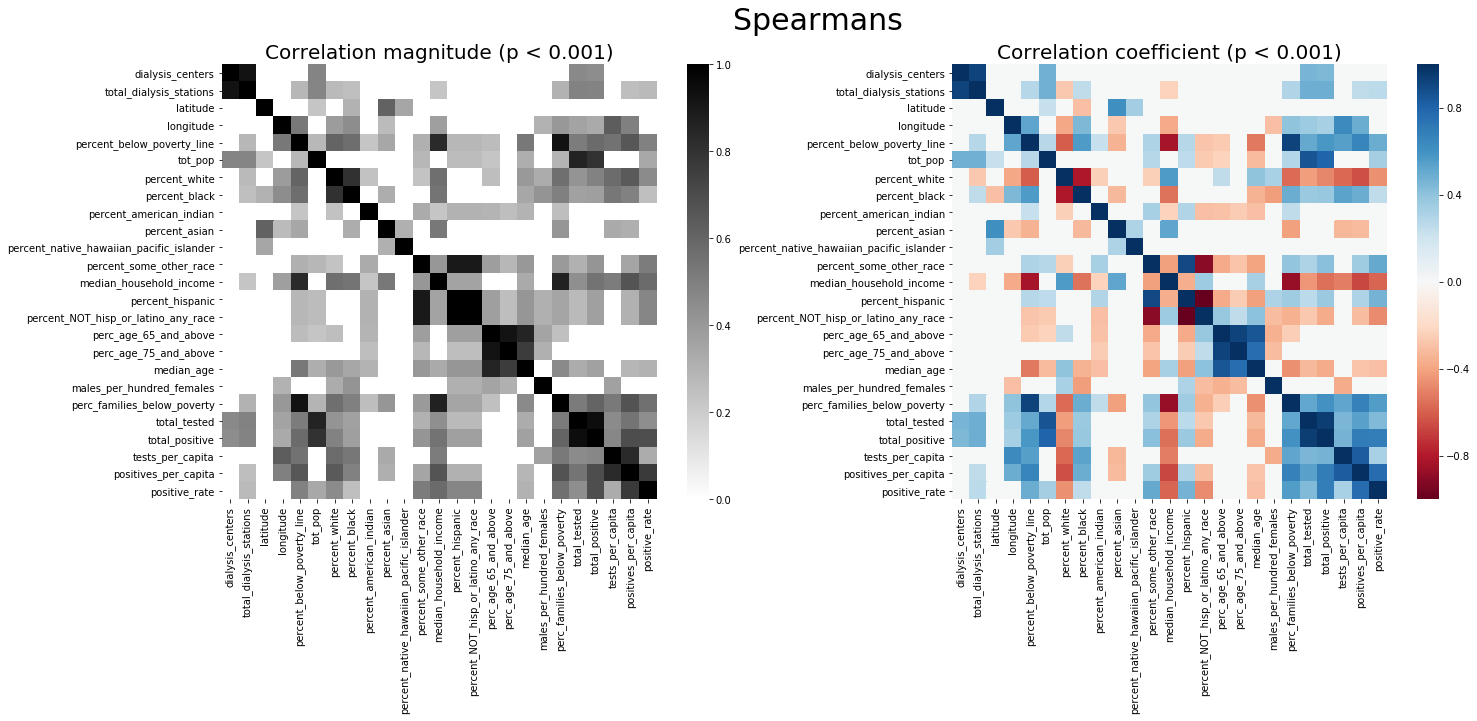

In [16]:
columns_of_interest = ['positives_per_capita','tests_per_capita', 'positive_rate', 'stations_per_center',
                       'stations_per_center','tot_pop']

pv = 0.001
df_spearman = pd.DataFrame(index = df_main.columns, columns = df_main.columns)
df_pearson = pd.DataFrame(index = df_main.columns, columns = df_main.columns)
for i,col in enumerate(df_main.columns):
    if col == 'il_zip':
        continue
    
    for j,row in enumerate(df_main.columns):
        
        if j < i:
            continue
    
        if row == 'il_zip':
            continue
        else:
            x = df_main[row]
            y = df_main[col]
            if scipy.stats.spearmanr(x,y).pvalue < pv:
                df_spearman.loc[row,col] = scipy.stats.spearmanr(x,y).correlation
                df_spearman.loc[col,row] = scipy.stats.spearmanr(y,x).correlation

            else:
                 df_spearman.loc[row,col] = 0  
                 df_spearman.loc[col,row] = 0 
                    
            if scipy.stats.pearsonr(x,y)[1] < pv:
                df_pearson.loc[row,col] = scipy.stats.pearsonr(x,y)[0]
                df_pearson.loc[col,row] = scipy.stats.pearsonr(y,x)[0]
            else:
                
                    
                df_pearson.loc[col,row] = 0
                df_pearson.loc[row,col] = 0

df_spearman = df_spearman.drop('il_zip', axis =0).drop('il_zip', axis =1).astype(float)
plt.figure(figsize = (24,8))

plt.subplot(1,2,1)
sns.heatmap(np.abs(df_spearman), vmax=1, vmin = 0, square=True, cmap = 'binary')
plt.title(f'Correlation magnitude (p < {pv})', fontsize = 20)

plt.subplot(1,2,2)
sns.heatmap(df_spearman, vmax=1, vmin = -1, square=True, cmap = 'RdBu')
plt.title(f'Correlation coefficient (p < {pv})', fontsize = 20)
plt.suptitle('Spearmans', fontsize = 30)

Text(0.5, 0.98, 'Pearsons')

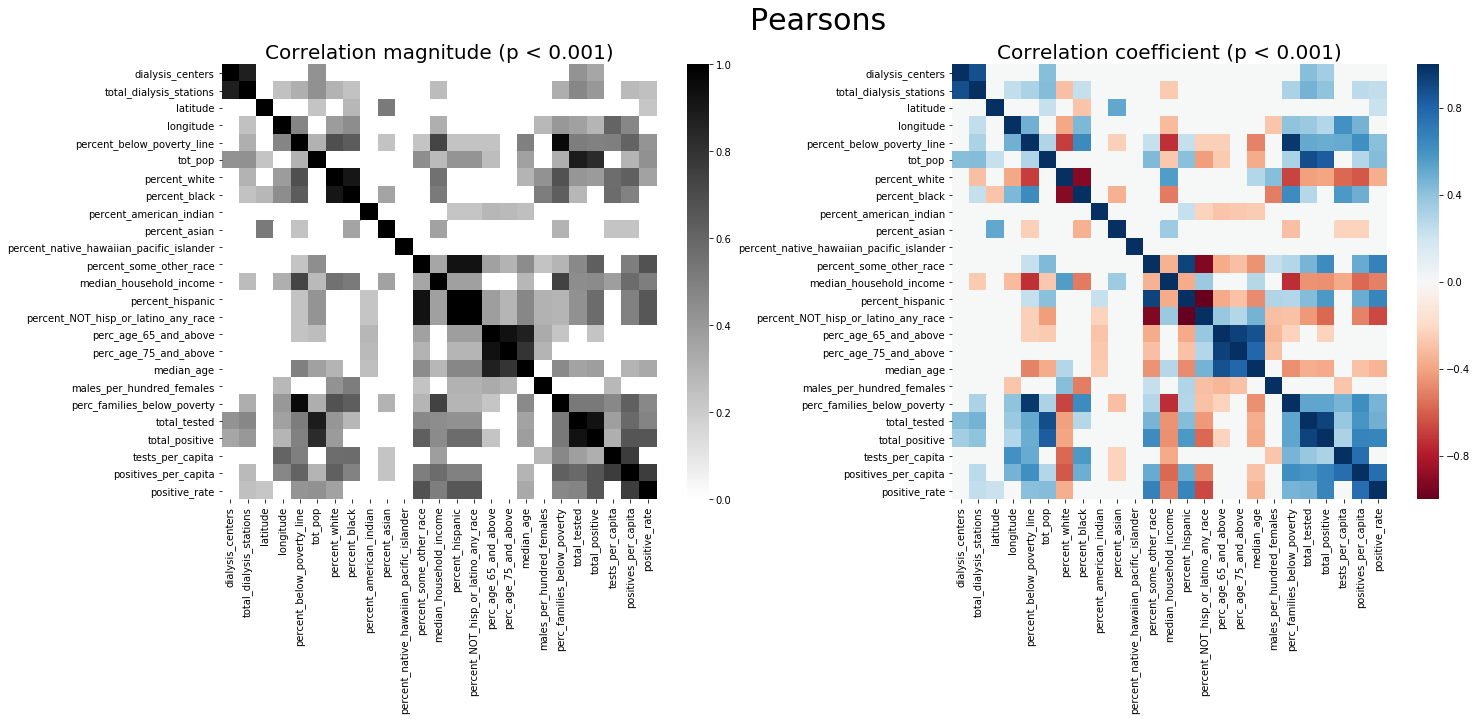

In [17]:
df_pearson = df_pearson.drop('il_zip', axis =0).drop('il_zip', axis =1).astype(float)
plt.figure(figsize = (24,8))

plt.subplot(1,2,1)
sns.heatmap(np.abs(df_pearson), vmax=1, vmin = 0, square=True, cmap = 'binary')
plt.title(f'Correlation magnitude (p < {pv})', fontsize = 20)

plt.subplot(1,2,2)
sns.heatmap(df_pearson, vmax=1, vmin = -1, square=True, cmap = 'RdBu')
plt.title(f'Correlation coefficient (p < {pv})', fontsize = 20)
plt.suptitle('Pearsons', fontsize = 30)

In [32]:
df_spearman[['positive_rate', 
             'positives_per_capita']].drop(['positive_rate', 
                                            'positives_per_capita'])#.query("positives_> 0")

,positive_rate,positives_per_capita
dialysis_centers,0.000000,0.000000
total_dialysis_stations,0.269747,0.253980
latitude,0.000000,0.000000
longitude,0.000000,0.496325
percent_below_poverty_line,0.494039,0.659696
tot_pop,0.340124,0.000000
percent_white,-0.455727,-0.647259
percent_black,0.250072,0.494473
percent_american_indian,0.000000,0.000000
percent_asian,0.000000,-0.313033


In [18]:
print('Correlations with dialysis stations')

dialysis_variables = ['total_dialysis_stations','dialysis_centers']
dependant_variables = ['tests_per_capita', 'positives_per_capita', 'percent_below_poverty_line',
                       'positive_rate', 'total_positive', 'total_tested']
x = df_spearman.loc[dialysis_variables, dependant_variables]
x[abs(x)>0]

Correlations with dialysis stations


,tests_per_capita,positives_per_capita,percent_below_poverty_line,positive_rate,total_positive,total_tested
total_dialysis_stations,NaN,0.25398,0.282781,0.269747,0.487157,0.488666
dialysis_centers,NaN,NaN,NaN,NaN,0.447471,0.460961


In [19]:
df_main.percent_below_poverty_line.median()

8.850000000000001

In [20]:
print('Correlations with poverty and income')

dialysis_variables = ['median_household_income','percent_below_poverty_line']
dependant_variables = ['tests_per_capita', 'positives_per_capita',
                       'positive_rate', 'total_positive', 'total_tested']
x = df_spearman.loc[dialysis_variables, dependant_variables]
x[abs(x)>0]

Correlations with poverty and income


,tests_per_capita,positives_per_capita,positive_rate,total_positive,total_tested
median_household_income,-0.515207,-0.670219,-0.581330,-0.547481,-0.440337
percent_below_poverty_line,0.552927,0.659696,0.494039,0.578177,0.514464


In [21]:
# Racial correlations
race_list = ['percent_white', 'percent_black', 'percent_asian', 'percent_hispanic']
dependant_variables = ['tests_per_capita', 'positives_per_capita', 'percent_below_poverty_line',
                       'positive_rate', 'total_positive', 'total_tested']
x = df_spearman[race_list].dropna()
x.loc[dependant_variables, race_list]

,percent_white,percent_black,percent_asian,percent_hispanic
tests_per_capita,-0.577716,0.534184,-0.333355,0.000000
positives_per_capita,-0.647259,0.494473,-0.313033,0.307509
percent_below_poverty_line,-0.607271,0.566465,-0.346516,0.282443
positive_rate,-0.455727,0.250072,0.000000,0.473061
total_positive,-0.490055,0.378355,0.000000,0.371511
total_tested,-0.419281,0.367478,0.000000,0.270031


In [22]:
df_main.columns

Index(['il_zip', 'dialysis_centers', 'total_dialysis_stations', 'latitude',
       'longitude', 'percent_below_poverty_line', 'tot_pop', 'percent_white',
       'percent_black', 'percent_american_indian', 'percent_asian',
       'percent_native_hawaiian_pacific_islander', 'percent_some_other_race',
       'median_household_income', 'percent_hispanic',
       'percent_NOT_hisp_or_latino_any_race', 'perc_age_65_and_above',
       'perc_age_75_and_above', 'median_age', 'males_per_hundred_females',
       'perc_families_below_poverty', 'total_tested', 'total_positive',
       'tests_per_capita', 'positives_per_capita', 'positive_rate'],
      dtype='object')

In [23]:
group1, group2 = 'total_dialysis_stations','positive_rate'
r, p, lo, hi = pearsonr_ci(df_main[group1],df_main[group2],alpha=0.01)
print(group1, ',', group2)
print(r.round(2), p, lo.round(3), hi.round(3))
print()
group1, group2 = 'total_dialysis_stations','positives_per_capita'
r, p, lo, hi = pearsonr_ci(df_main[group1],df_main[group2],alpha=0.01)
print(group1, ',', group2)
print(r.round(2), p, lo.round(3), hi.round(3))

total_dialysis_stations , positive_rate
0.25 0.00019717096911018512 0.079 0.404

total_dialysis_stations , positives_per_capita
0.27 4.0012637858499386e-05 0.105 0.426


# Least squares model

In [24]:
formula = 'positive_rate ~ total_dialysis_stations + percent_below_poverty_line + \
            percent_black + percent_hispanic + 1'
systolic_lm = ols(formula,data=df_main).fit()
table = anova_lm(systolic_lm, typ=2) # Type 2 ANOVA DataFrame
print(table)
# plt.figure()
# g = sns.scatterplot(y = 'positive_rate', x = 'percent_below_poverty_line', data = df_main)
# X, Y = df_main['percent_below_poverty_line'].values.reshape(-1,1), df_main['positive_rate'].values.reshape(-1,1)
# plt.plot( X, LinearRegression().fit(X, Y).predict(X), color = 'k')


formula = 'positives_per_capita ~ total_dialysis_stations + percent_below_poverty_line + \
            percent_black + percent_hispanic'
systolic_lm = ols(formula,data=df_main).fit()
table = anova_lm(systolic_lm, typ=2) # Type 2 ANOVA DataFrame
print(table)
# plt.figure()
# g = sns.scatterplot(y = 'positives_per_capita', x = 'percent_below_poverty_line', data = df_main)
# X, Y = df_main['percent_below_poverty_line'].values.reshape(-1,1), df_main['positives_per_capita'].values.reshape(-1,1)
# plt.plot( X, LinearRegression().fit(X, Y).predict(X), color = 'k')

                              sum_sq     df           F        PR(>F)
total_dialysis_stations     0.001312    1.0    0.451534  5.023290e-01
percent_below_poverty_line  0.012524    1.0    4.309669  3.908548e-02
percent_black               0.018062    1.0    6.215296  1.341946e-02
percent_hispanic            0.406951    1.0  140.036893  3.288103e-25
Residual                    0.624796  215.0         NaN           NaN
                                  sum_sq     df           F        PR(>F)
total_dialysis_stations     2.919223e-08    1.0    0.004634  9.457923e-01
percent_below_poverty_line  5.468216e-05    1.0    8.679698  3.572270e-03
percent_black               3.532059e-04    1.0   56.064362  1.786045e-12
percent_hispanic            7.289262e-04    1.0  115.702449  7.198345e-22
Residual                    1.354502e-03  215.0         NaN           NaN


                              sum_sq     df          F        PR(>F)
percent_below_poverty_line  0.230367    1.0  46.376274  9.350858e-11
Residual                    1.082880  218.0        NaN           NaN
                              sum_sq     df           F        PR(>F)
percent_below_poverty_line  0.001291    1.0  130.237056  5.887412e-24
Residual                    0.002162  218.0         NaN           NaN


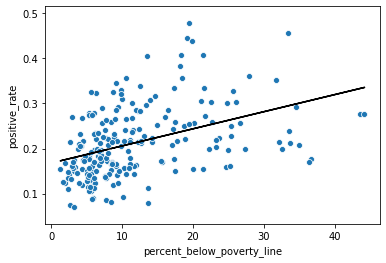

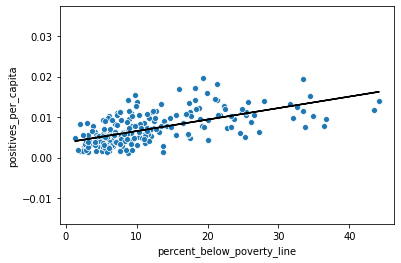

In [25]:
# Ordinary least squares

formula = 'positive_rate ~ percent_below_poverty_line'
systolic_lm = ols(formula,data=df_main).fit()
table = anova_lm(systolic_lm, typ=2) # Type 2 ANOVA DataFrame
print(table)
plt.figure()
g = sns.scatterplot(y = 'positive_rate', x = 'percent_below_poverty_line', data = df_main)
X, Y = df_main['percent_below_poverty_line'].values.reshape(-1,1), df_main['positive_rate'].values.reshape(-1,1)
plt.plot( X, LinearRegression().fit(X, Y).predict(X), color = 'k')


formula = 'positives_per_capita ~ percent_below_poverty_line'
systolic_lm = ols(formula,data=df_main).fit()
table = anova_lm(systolic_lm, typ=2) # Type 2 ANOVA DataFrame
print(table)
plt.figure()
g = sns.scatterplot(y = 'positives_per_capita', x = 'percent_below_poverty_line', data = df_main)
X, Y = df_main['percent_below_poverty_line'].values.reshape(-1,1), df_main['positives_per_capita'].values.reshape(-1,1)
plt.plot( X, LinearRegression().fit(X, Y).predict(X), color = 'k')

                              sum_sq     df          F        PR(>F)
percent_below_poverty_line  0.230367    1.0  46.376274  9.350858e-11
Residual                    1.082880  218.0        NaN           NaN
                              sum_sq     df          F        PR(>F)
percent_below_poverty_line  0.230367    1.0  46.376274  9.350858e-11
Residual                    1.082880  218.0        NaN           NaN


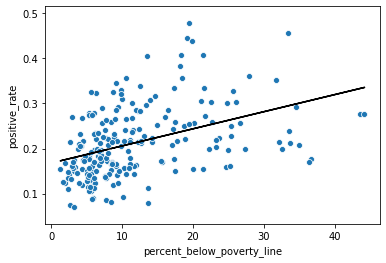

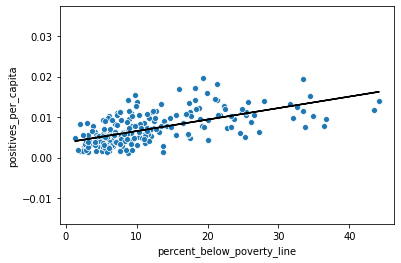

In [26]:
# generalized least squares

formula = 'positive_rate ~ percent_below_poverty_line'
systolic_glm = gls(formula,data=df_main).fit()
table = anova_lm(systolic_glm, typ=2) # Type 2 ANOVA DataFrame
print(table)
plt.figure()
g = sns.scatterplot(y = 'positive_rate', x = 'percent_below_poverty_line', data = df_main)
X, Y = df_main['percent_below_poverty_line'].values.reshape(-1,1), df_main['positive_rate'].values.reshape(-1,1)
plt.plot( X, LinearRegression().fit(X, Y).predict(X), color = 'k')


formula = 'positives_per_capita ~ percent_below_poverty_line'
systolic_lm = gls(formula,data=df_main).fit()
table = anova_lm(systolic_glm, typ=2) # Type 2 ANOVA DataFrame
print(table)
plt.figure()
g = sns.scatterplot(y = 'positives_per_capita', x = 'percent_below_poverty_line', data = df_main)
X, Y = df_main['percent_below_poverty_line'].values.reshape(-1,1), df_main['positives_per_capita'].values.reshape(-1,1)
plt.plot( X, LinearRegression().fit(X, Y).predict(X), color = 'k')

In [27]:
# Linear regression model
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
reg = linear_model.LinearRegression()

df_main['const'] = 1
independant_variables = ['total_dialysis_stations', 
                         'percent_below_poverty_line', 'tot_pop', 
                         'percent_white','percent_black', 'percent_asian','percent_hispanic', 'const']


# df_rank = df_main.copy()
# L = len(df_rank)
# for col in df_main.columns:
#     if col == 'il_zip':
#         continue
#     df_rank[col] = df_rank[col].rank(method='max')/L # - df_rank[col].mean())/df_rank[col].std()

dependant_variable = 'positives_per_capita'
#dependant_variable = 'positive_rate'

X = df_main[independant_variables]
y = df_main[dependant_variable]


X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=49) 




In [28]:
# Linear Regrression
reg_all = linear_model.LinearRegression()
reg_all.fit(X_train, y_train) 
y_pred = reg_all.predict(X_test)
reg_all.score(X_test, y_test)

print(len(reg_all.coef_), len(independant_variables))

# coefficients
df_lin_reg = {}
df_lin_reg['variables'] = independant_variables
df_lin_reg['coeffs'] = reg_all.coef_

cv_results = cross_val_score(reg_all, X, y, cv=5)
print(cv_results)
df = pd.DataFrame(df_lin_reg)
df.coeffs = df.coeffs/df.coeffs.sum()
df

8 8
[0.60541924 0.45725513 0.34152809 0.4073849  0.23416635]


,variables,coeffs
0,total_dialysis_stations,0.045848
1,percent_below_poverty_line,0.204241
2,tot_pop,0.000014
3,percent_white,0.006093
4,percent_black,0.240762
5,percent_asian,0.103188
6,percent_hispanic,0.399854
7,const,0.000000
